<a href="https://colab.research.google.com/github/houman-nr/vigilant-umbrella/blob/main/ORL_on_SRL_Transfer-Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers
! pip install torch

### importing libraries

In [2]:
import torch
import numpy as np
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import json
import random
from sklearn.model_selection import train_test_split
from itertools import zip_longest

### defining general variables

In [3]:
#defining global valriables throughout the whole notebook
EPOCH = 32
BATCH_SIZE = 64
MAX_INPUT_LENGTH = 65
MAX_LABEL_LENGTH = 8
MODEL_LINK = "google/flan-t5-small"
FOLD_NUMBER = 4
SEED = 0
srl_data_link = '/kaggle/input/srl-w-cluster-number103k/SRL_Dataset_With_60_Clusters-Similarity.csv'
state_dictionary = '/kaggle/input/t5-small_fine-tuned_mpqa/pytorch/0/2/output (1).pt'

In [4]:
def set_seed():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [5]:
set_seed()
tokenizer = T5Tokenizer.from_pretrained(MODEL_LINK, legacy=False)
model = T5ForConditionalGeneration.from_pretrained(MODEL_LINK).to('cuda')

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### functions created for reading(get_data) and organize the files (organize_data)

In [6]:
from torch.utils.data import DataLoader, Dataset
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length4text, max_length4label):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length4text = max_length4text
        self.max_length4label = max_length4label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        agent_prompt = self.data['agent_prompt'][idx]
        target_prompt = self.data['target_prompt'][idx]
        agent = self.data['agent'][idx]
        target = self.data['target'][idx]
        # tokenizing agent prompt
        agent_prompt_encoding = self.tokenizer(agent_prompt, truncation=True, padding='max_length', max_length=self.max_length4text, return_tensors='pt').to("cuda")
        # tokenizing target prompt
        target_prompt_encoding = self.tokenizer(target_prompt, truncation=True, padding='max_length', max_length=self.max_length4text, return_tensors='pt').to("cuda")
        # tokenizing agent
        agent_encoding = self.tokenizer(agent, truncation=True, padding='max_length', max_length=self.max_length4label, return_tensors='pt').to("cuda")
        # tokenizing target
        target_encoding = self.tokenizer(target, truncation=True, padding='max_length', max_length=self.max_length4label, return_tensors='pt').to("cuda")
        return {
            # agent prompt
            'agent_input_id': agent_prompt_encoding['input_ids'].squeeze(),
            'agent_attention_mask': agent_prompt_encoding['attention_mask'].squeeze(),
            # target prompt
            'target_input_id': target_prompt_encoding['input_ids'].squeeze(),
            'target_attention_mask': target_prompt_encoding['attention_mask'].squeeze(),
            #agent
            'agent_id': agent_encoding['input_ids'].squeeze(),
            'agent_mask': agent_encoding['attention_mask'].squeeze(),
            #target
            'target_id': target_encoding['input_ids'].squeeze(),
            'target_mask': target_encoding['attention_mask'].squeeze()
        }

In [7]:
# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [8]:
def f1_calculator(split_pred_list, split_actual_list):
    matched, percision, recall, f1 = 0, 0, 0, 0
    predicted_len, actual_len      = 0, 0

    for actual_sublist, prediction_sublist in zip(split_pred_list, split_actual_list):
        predicted_len += len(prediction_sublist)
        for i in actual_sublist:
            actual_len += 1
            if i in prediction_sublist:
                matched += 1

    print(f"matched: {matched}, predicted_len: {predicted_len}, actual_len: {actual_len}")
    try:
        precision = matched / predicted_len
        recall = matched / actual_len
        f1 = 2 * (precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1 = 0

    return f1

In [9]:
def clear_data(text_list):
    list_of_items_in_text = []
    for single_list in text_list:
        for i in single_list.split('|'):
            i = i.lower().replace(" ", "")  # Convert to lowercase and remove extra whitespace
            if i:  # Check if `i` is not empty after stripping
                list_of_items_in_text.append(i)
    return list_of_items_in_text

In [10]:
def evaluate_model(model, dataloader, prompt_type):
    if prompt_type == 'target':
        id_type = 'target_input_id'
        attention_type = 'target_attention_mask'
        output_type = 'target_id'
    elif prompt_type == 'agent':
        id_type = 'agent_input_id'
        attention_type = 'agent_attention_mask'
        output_type = 'agent_id'

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        actual_list, prediction_list = [], []
        for batch_idx, batch in enumerate(dataloader):

            # Forward pass
            ids = batch[id_type]
            mask = batch[attention_type]
            output_id = batch[output_type]

            actuals = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in output_id]

            generated_output = model.generate(
              input_ids = ids,
              attention_mask = mask,
              max_length=64,
              )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_output]

            actual_list.append(clear_data(actuals))
            prediction_list.append(clear_data(preds))

    return f1_calculator(prediction_list, actual_list)

In [11]:
f1_scores_target, f1_scores_agent = [], []
#           data_loader:train,v_data_loader:validation
def train_data(data_loader, v_data_loader):
    data_list = []
    model.train()
    for epoch in range(EPOCH):
        losses = []
        for batch in data_loader:

            agent_input = batch['agent_input_id']
            agent_attention_mask = batch['agent_attention_mask']

            target_input = batch['target_input_id']
            target_attention_mask = batch['target_attention_mask']

            agent_id = batch['agent_id']
            agent_mask = batch['agent_mask']

            target_id = batch['target_id']
            target_mask = batch['target_mask']

            optimizer.zero_grad()

            agent_output = model(agent_input, attention_mask=agent_attention_mask, labels=agent_id)
            target_output = model(target_input, attention_mask=target_attention_mask, labels=target_id)

            agent_loss = agent_output.loss
            target_loss = target_output.loss
            losses.append(agent_loss.item())
            losses.append(target_loss.item())

            agent_loss.backward()
            target_loss.backward()
            optimizer.step()


        f1_4_target = evaluate_model(model, v_data_loader, 'target')
        f1_4_agent = evaluate_model(model, v_data_loader, 'agent')

        f1_scores_target.append(f1_4_target)
        f1_scores_agent.append(f1_4_agent)

        # report the results of training function.
        print(f'loss: {np.mean(losses)}, f1 for target:{f1_4_target}, f1 for agent:{f1_4_agent} \n end of epoch{epoch}. \n')

# Training t5-small on SRL (srl dev and test too)
# first part of 2 transfer learning sections

### .
### .
### .
### .
## chosing randomly out of SRL_without_anchors for calculating the results
### .
### .
### .
### .

In [12]:
# srl = pd.read_csv(srl_data_link)
# agents, targets, verbs, sentences, cluster_number = [], [], [], [], []
# for i in range(len(srl)):

#     #single line of data is selected from df
#     line = srl.iloc[i]

#     #check for both ARGS,
#     #if both are empty skips that line.
#     #if either one of the args is filled-
#     #-process continues.
#     if line['ARG0'] or line['ARG1']:
#         if line['ARG0']:
#             agents.append(line['ARG0'])
#         else:
#             agents.append("")
#         if line['ARG1']:
#             targets.append(line['ARG1'])
#         else:
#             targets.append("")
#         sentences.append(line['SENTENCE'])
#         verbs.append(line['PREDICATES'])
#         cluster_number.append(line['Cluster_Number'])

# srl_df = pd.DataFrame({'sentences': sentences, 'verbs': verbs, 'agents': agents, 'targets': targets, 'cluster_no':cluster_number}, dtype='object').fillna('')
# srl_df

In [13]:
# agent_prompts, agents, target_prompts, targets, cluster_no = [], [], [], [], []
# for i in range(len(srl_df)):
#     line = srl_df.iloc[i]
#     agent_prompts.append(f"sentence is: {line['sentences']} this is verb: {line['verbs']} find agent for this veerb in the sentence")
#     agents.append(line['agents'])
#     target_prompts.append(f"sentence is: {line['sentences']} this is verb: {line['verbs']} find target for this verb in the sentence")
#     targets.append(line['targets'])
#     cluster_no.append(line['cluster_no'])
#     # (f"sentence is: \{{input_df['sentence'][i]}} this is DSE: {input_df['dse'][i]}. find target for DSE in the sentence?")
# srl_df = []
# srl_df = pd.DataFrame({'agent_prompt': agent_prompts, 'agent': agents, 'target_prompt': target_prompts, 'target': targets, 'cluster_no':cluster_no})
# srl_df

#### randomly selecting number of this dataframe to be fed into the model

##### 4000 lines of data is the limit of notebook with GPU T4*2 memory limit
##### 60 clusters to chose from, Results in almost 66.6... from each cluster

In [14]:
# def random_sample_df(df, num_rows, SEED=None):
#     # Check if num_rows is larger than the available number of rows in the DataFrame
#     if num_rows > len(df):
#         raise ValueError(f"Requested {num_rows} rows, but the DataFrame only contains {len(df)} rows.")

#     # Sample the DataFrame and return the result
#     sampled_df = df.sample(n=num_rows, random_state=SEED)
#     return sampled_df

# def random_sample_from_all_clusters(df, num_rows_per_cluster, cluster_column, SEED=None):
#     # Check if the cluster_column exists in the DataFrame
#     if cluster_column not in df.columns:
#         raise ValueError(f"Column '{cluster_column}' not found in DataFrame.")

#     # Create an empty list to hold the sampled data for each cluster
#     sampled_dfs = []

#     # Group the DataFrame by the cluster column
#     grouped = df.groupby(cluster_column)

#     # Iterate over each cluster and sample rows
#     for cluster, group in grouped:
#         # Check if the group has enough rows to sample
#         if len(group) < num_rows_per_cluster:
#             raise ValueError(f"Cluster '{cluster}' has only {len(group)} rows, but {num_rows_per_cluster} were requested.")

#         # Sample the rows from the current cluster
#         sampled_group = group.sample(n=num_rows_per_cluster, random_state=SEED)
#         sampled_dfs.append(sampled_group)

#     # Concatenate the sampled DataFrames for each cluster
#     sampled_df = pd.concat(sampled_dfs).reset_index(drop=True)

#     return sampled_df


# srl_nk = random_sample_from_all_clusters(srl_df, 170, 'cluster_no', SEED)
# srl_test_df = srl_nk[:1500]
# srl_dev_df = srl_nk[1501:3992]
# srl_train_df = srl_nk[3993:]
# srl_train_df.reset_index(inplace=True, drop=True)
# srl_test_df.reset_index(inplace=True, drop=True)
# srl_dev_df.reset_index(inplace=True, drop=True)
# srl_train_df

In [15]:
# # srl dataset for train
# # orl dev set for validation
# # orl test set for testing


# # Create a data loader for TRAIN dataframe
# train_dataset = CustomDataset(srl_train_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
# train_data_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True)

# # Create a data loader for EVALUATION dataframe
# val_dataset = CustomDataset(srl_dev_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
# val_data_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=False)

# # Create a data loader for TEST dataframe
# test_dataset = CustomDataset(srl_test_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
# test_data_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle=False)


In [16]:
# train_data(train_data_loader, val_data_loader)

In [17]:
# import matplotlib.pyplot as plt
# # Plot F1 scores for target and agent
# epochs = range(0, EPOCH)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, f1_scores_target, label='F1 Target', marker='o')
# plt.plot(epochs, f1_scores_agent, label='F1 Agent', marker='o')

# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.title('F1 Scores for Target and Agent over Epochs')
# plt.legend()
# plt.grid(True)
# plt.show()

In [18]:
# target_accuracy = evaluate_model(model, val_data_loader, 'target')
# agent_accuracy = evaluate_model(model, val_data_loader, 'agent')
# print(f'f1 Agent: {agent_accuracy}. f1 Target: {target_accuracy}\n\n----------------------')

In [19]:
# torch.save(model.state_dict(), 'output.pt')

# Feeding state dictionary of the previously trained model and fine-tuning model on ORL data.
## 

In [20]:
model.load_state_dict(torch.load('/kaggle/input/t5-small_fine-tuned_mpqa/pytorch/0/2/output (1).pt'))

<ipython-input-20-8c7c6e68c4eb>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/t5-small_fine-tuned_mpqa/pytorch/0/2/output 

<All keys matched successfully>

In [21]:
# a funciton to read data off of a database link is here to help getting and organizing data into dataframes
def get_data(address):
    lines = []
    with open(address) as file:
        for line in file:
            x = json.loads(line)
            lines.append(x)
    sentences, orl, sep_sentences = [], [], []
    for i in range(len(lines)):
        sep_sentences.append(lines[i]['sentences'])
        sentences.append(' '.join(lines[i]['sentences']))
        orl.append(lines[i]['orl'])
    dataframe = pd.DataFrame({'sentence': sentences, 'orl': orl, 'sep_sent': sep_sentences})
    return dataframe

# this function is to make a list of the said attribute for later iterations
def list_of(attributes, requested_atr):
    requested_list = []
    for sublist in attributes:
        if sublist[-1] == requested_atr:
            requested_list.append(sublist)
    return requested_list

# this function was made to find target(s)/agent(s) of a dse according to list of attributes
def organize_data(dataframe):
    
    target_column, agent_column, sentence_column, dse_column = [], [], [], []
    
    for i in range(len(dataframe)):
        
        attributes = dataframe['orl'][i]
        sentence   = dataframe['sep_sent'][i]
        target_list= list_of(attributes, 'TARGET')
        agent_list = list_of(attributes, 'AGENT')
        AGENT, DSE, TARGET = '', '', ''
        
        
        for sublist in attributes:
            if sublist[-1] == 'DSE':
                dse_start = int(sublist[0])
                dse_end = int(sublist[1] + 1)
                DSE += ' '.join(sentence[dse_start:dse_end]) + '|'
                
                
                # looking for the targets and agents of this dse that we have found
                for sub_sublist in target_list:
                    if sub_sublist[0] == dse_start and int(sub_sublist[1] + 1) == dse_end:
                        target_start = int(sub_sublist[2])
                        target_end = int(sub_sublist[3] + 1)
                        TARGET += ' '.join(sentence[target_start:target_end]) + ' |'
                if not TARGET:
                    TARGET += ' |'
                
                for sub_sublist in agent_list:
                    if sub_sublist[0] == dse_start and int(sub_sublist[1] + 1) == dse_end:
                        agent_start = int(sub_sublist[2])
                        agent_end = int(sub_sublist[3] + 1)
                        AGENT += ' '.join(sentence[agent_start:agent_end]) + '|'
                if not AGENT:
                    AGENT += ' |'
                # for every iteration of loop over attributes, if a dse is found, then we need to transfer it to new line of a dataframe
                # for each one of the dse(s) i have to add them into a new array so then they can create the correct dataframe
                target_column.append(TARGET)
                agent_column.append(AGENT)
                dse_column.append(DSE)
                sentence_column.append(dataframe['sentence'][i])

    # end of iteration on all sentences
    output_df = pd.DataFrame({'sentence':sentence_column, 'dse':dse_column, 'target':target_column, 'agent':agent_column})
    return output_df

In [22]:
def get_files_of_folder(folder_number):
    folder = f"/kaggle/input/ds-json-format/json_format_dataset/{folder_number}"
    dev_df = get_data(f"{folder}/aaai19srl.dev{folder_number}.conll.json")
    df = get_data(f"{folder}/aaai19srl.train{folder_number}.conll.json")
    test_df = get_data(f"{folder}/aaai19srl.test{folder_number}.conll.json")
    return df, dev_df, test_df
df = get_files_of_folder(FOLD_NUMBER)[0]
dev_df = get_files_of_folder(FOLD_NUMBER)[1]
test_df = get_files_of_folder(FOLD_NUMBER)[2]

In [23]:
# df = get_data("/kaggle/input/ds-json-format/json_format_dataset/0/aaai19srl.train0.conll.json")

df = organize_data(df)
dev_df = organize_data(dev_df)
test_df = organize_data(test_df)
df

,sentence,dse,target,agent
0,Private organizations are also being encourage...,are also being encouraged|,help fight sandstorms |,|
1,"It is believed that sand from northern areas ,...",is believed|,"sand from northern areas , especially the Inne...",|
2,`` Since our technical equipment is far from p...,said|,our technical equipment |we |,Nazarov|
3,`` Our agency seriously needs equipment for de...,seriously needs|,equipment for detecting drugs |,|
4,`` Our agency seriously needs equipment for de...,seriously needs|said|,equipment for detecting drugs |Our agency |,|he|
...,...,...,...,...
3480,"Esselte AB , the Stockholm office supplies com...",proposed|,to acquire the 22 % it does n't own of its U.S...,"Esselte AB , the Stockholm office supplies com..."
3481,A committee of outside directors for the Garde...,asked|,|,the parent|
3482,The unit said it can provide no assurance a tr...,can provide no assurance|,a transaction will occur |,The unit|
3483,"Jay Stevens , an analyst with Dean Witter Reyn...",expected|,|,he|


In [24]:
def create_prompt(input_df):
    target_prompt, agent_prompt, target, agent, sentence, dse = [], [], [], [], [], []
    for i in range(len(input_df)):
        target_prompt.append(f"sentence is: {input_df['sentence'][i]} this is verb: {input_df['dse'][i]}. find target for DSE in the sentence?")
        agent_prompt.append(f"sentence is: {input_df['sentence'][i]} this is verb: {input_df['dse'][i]}. find agent for DSE in the sentence?")
        target.append(input_df['target'][i])
        agent.append(input_df['agent'][i])
        sentence.append(input_df['sentence'][i])
        dse.append(input_df['dse'][i])
    output_df = pd.DataFrame({'sentence':sentence, 'dse':dse, 'target_prompt':target_prompt, 'target':target, 'agent_prompt':agent_prompt, 'agent':agent})
    return output_df

In [25]:
dev_df = create_prompt(dev_df).reset_index(drop=True)
train_df = create_prompt(df).reset_index(drop=True)
test_df = create_prompt(test_df).reset_index(drop=True)

In [26]:
# Create a data loader for TRAIN dataframe 
train_dataset = CustomDataset(train_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
train_data_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True)

# Create a data loader for EVALUATION dataframe
val_dataset = CustomDataset(dev_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
val_data_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=False)

# Create a data loader for TEST dataframe
test_dataset = CustomDataset(test_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
test_data_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle=False)

In [27]:
train_data(train_data_loader, val_data_loader)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


matched: 555, predicted_len: 1488, actual_len: 1375
matched: 1051, predicted_len: 1586, actual_len: 1509
loss: 0.9594276630065658, f1 for target:0.3877052043311212, f1 for agent:0.6791599353796446 
 end of epoch0. 

matched: 573, predicted_len: 1488, actual_len: 1234
matched: 1002, predicted_len: 1586, actual_len: 1389
loss: 0.36015350899913096, f1 for target:0.4210139603232917, f1 for agent:0.6736134453781513 
 end of epoch1. 

matched: 657, predicted_len: 1488, actual_len: 1420
matched: 1032, predicted_len: 1586, actual_len: 1496
loss: 0.22857713116840883, f1 for target:0.451856946354883, f1 for agent:0.6696950032446463 
 end of epoch2. 

matched: 660, predicted_len: 1488, actual_len: 1442
matched: 1049, predicted_len: 1586, actual_len: 1460
loss: 0.14734081842682578, f1 for target:0.45051194539249145, f1 for agent:0.6887721602101117 
 end of epoch3. 

matched: 684, predicted_len: 1488, actual_len: 1438
matched: 1023, predicted_len: 1586, actual_len: 1424
loss: 0.11311241489919749, f

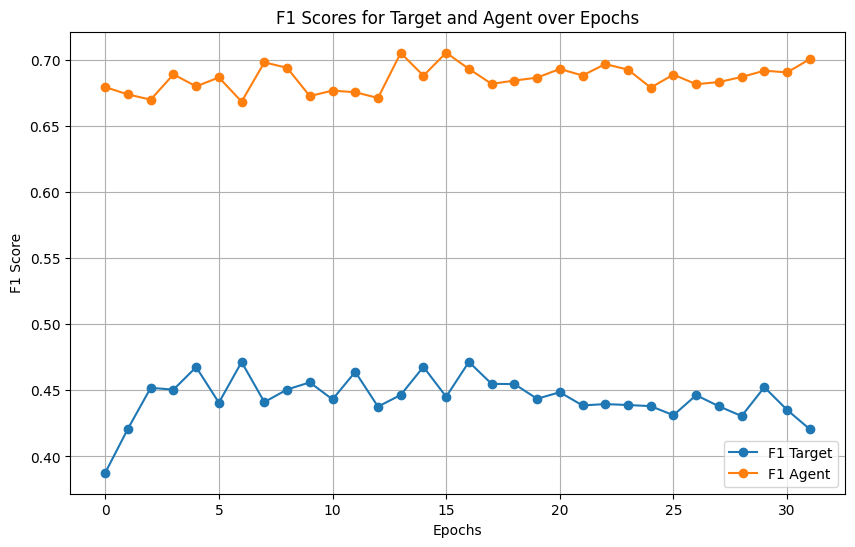

In [28]:
import matplotlib.pyplot as plt
# Plot F1 scores for target and agent
epochs = range(0, EPOCH)

plt.figure(figsize=(10, 6))
plt.plot(epochs, f1_scores_target, label='F1 Target', marker='o')
plt.plot(epochs, f1_scores_agent, label='F1 Agent', marker='o')

plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Target and Agent over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
target_accuracy = evaluate_model(model, val_data_loader, 'target')
agent_accuracy = evaluate_model(model, val_data_loader, 'agent')
print(f'f1 Agent: {agent_accuracy}. f1 Target: {target_accuracy}\n\n----------------------')

matched: 613, predicted_len: 1488, actual_len: 1427
matched: 1069, predicted_len: 1586, actual_len: 1467
f1 Agent: 0.700294792007861. f1 Target: 0.4205831903945112

----------------------


================ test =============== valdiation ============ score values


0. fold 0:
* * Agent : 0.7620064034151548 - 0.6803995006242197
* * Target: 0.4183908045977011 - 0.46626180836707154

1.  fold 1:
* * Agent : 0.6957424714434061 - 0.6730578512396694
* * Target: 0.4331004836109618 - 0.446286701208981

2. fold 2:
* * Agent : 0.7141242937853107 - 0.7063122923588041
* * Target: 0.45895745955662076- 0.45473537604456826


3. fold 3:
* * Agent : 0.6853932584269663 - 0.6834862385321102
* * Target: 0.4585561497326203 - 0.48108108108108105

4. fold 4:
* * Agent : 0.7492195629552549 - 0.700294792007861
* * Target: 0.48866777224986185- 0.4205831903945112
